# Cell 0 - Accumulation Signal Sandbox
Explore alternate short-signal formulas using daily_metrics data (read-only). No database writes.

In [51]:
# Cell 1 - Imports and Configuration
from pathlib import Path
import sys

import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

project_root = Path.cwd()
if (project_root / 'darkpool_analysis').exists():
    sys.path.insert(0, str(project_root))

from darkpool_analysis.config import load_config

config = load_config()

TICKER = 'XLE'
START_DATE = '2025-11-01'
END_DATE = '2025-12-31'
DB_PATH = config.db_path

DOT_MODE = 'current'  # 'current', 'option_a', 'option_b', 'all'
BLEND_SHORT_WEIGHT = 0.6
BLEND_FLOW_WEIGHT = 0.4

In [52]:
# Cell 2 - Styling Constants and Helper Functions
import matplotlib.dates as mdates

COLORS = {
    'background': '#0f0f10',
    'panel_bg': '#141416',
    'text': '#e6e6e6',
    'grid': '#2a2a2d',
    'white': '#ffffff',
    'green': '#00ff88',
    'red': '#ff6b6b',
    'yellow': '#ffd700',
    'cyan': '#00d4ff',
    'orange': '#ff9f43',
    'purple': '#b026ff',
    'neutral': '#6b6b6b',
    'blue': '#4aa3ff',
}
GRID_ALPHA = 0.18
OHLC_LINE_WIDTH = 1.2
SIGNAL_MARKER_SIZE = 60
SIGNAL_EDGE_WIDTH = 0.6

def _apply_axis_style(ax):
    ax.set_facecolor(COLORS['panel_bg'])
    ax.tick_params(colors=COLORS['text'], labelsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(COLORS['grid'])
    ax.spines['bottom'].set_color(COLORS['grid'])
    ax.grid(True, alpha=GRID_ALPHA, color=COLORS['grid'], linestyle='--')

def _format_volume(value):
    if pd.isna(value):
        return 'NA'
    value = float(value)
    if abs(value) >= 1_000_000_000:
        return f'{value / 1_000_000_000:.1f}B'
    if abs(value) >= 1_000_000:
        return f'{value / 1_000_000:.1f}M'
    if abs(value) >= 1_000:
        return f'{value / 1_000:.0f}K'
    return f'{value:,.0f}'

def _rolling_zscore(series, window, min_periods):
    """Compute rolling z-score with safe division."""
    rolling = series.rolling(window=window, min_periods=min_periods)
    mean = rolling.mean()
    std = rolling.std(ddof=0)
    # Avoid division by zero: replace 0 std with NaN
    std = std.replace(0, np.nan)
    return (series - mean) / std

def _sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def _compute_score_display(short_z, lit_z, price_z, otc_z, cfg):
    short = pd.to_numeric(short_z, errors='coerce').to_numpy(dtype=float)
    lit = pd.to_numeric(lit_z, errors='coerce').fillna(0.0).to_numpy(dtype=float)
    price = pd.to_numeric(price_z, errors='coerce').fillna(0.0).to_numpy(dtype=float)
    otc = pd.to_numeric(otc_z, errors='coerce').fillna(0.0).to_numpy(dtype=float)

    score = np.full_like(short, np.nan, dtype=float)
    valid = ~np.isnan(short)
    if valid.any():
        raw = (
            cfg.composite_w_short * np.tanh(short[valid] * 0.5)
            + cfg.composite_w_lit * np.tanh(lit[valid] * 0.5)
            + cfg.composite_w_price * np.tanh(price[valid] * 0.3)
        )
        intensity_range = cfg.intensity_scale_max - cfg.intensity_scale_min
        intensity = cfg.intensity_scale_min + intensity_range * _sigmoid(otc[valid])
        score[valid] = np.clip(raw * intensity, -1.0, 1.0)

    display = (score + 1.0) * 50.0
    return pd.Series(display, index=short_z.index)

def _set_flow_axis(ax, values):
    series = pd.to_numeric(values, errors='coerce')
    max_abs = series.abs().max(skipna=True)
    if pd.isna(max_abs) or max_abs == 0:
        max_abs = 1.0
    padding = max(max_abs * 0.1, 1.0)
    y_max = max_abs + padding
    y_min = -y_max
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.linspace(y_min, y_max, 5))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: _format_volume(x)))
    ax.axhline(0.0, color=COLORS['neutral'], linestyle='--', linewidth=1.2, alpha=0.7)

def _set_ratio_axis(ax, values, bot=1.25, sell=0.75):
    series = pd.to_numeric(values, errors='coerce')
    max_val = series.max(skipna=True)
    if pd.isna(max_val):
        max_val = 2.0
    upper = max(2.0, float(max_val) * 1.1)
    ax.set_ylim(0, upper)
    ax.axhline(1.0, color=COLORS['neutral'], linestyle='--', linewidth=1.0, alpha=0.6)
    ax.axhline(bot, color=COLORS['green'], linestyle='--', linewidth=1.0, alpha=0.8)
    ax.axhline(sell, color=COLORS['red'], linestyle='--', linewidth=1.0, alpha=0.8)

def _set_volume_axis(ax, values):
    series = pd.to_numeric(values, errors='coerce')
    max_val = series.max(skipna=True)
    if pd.isna(max_val) or max_val <= 0:
        max_val = 1.0
    y_max = max_val * 1.1
    ax.set_ylim(0, y_max)
    ax.set_yticks(np.linspace(0, y_max, 5))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: _format_volume(x)))

def _add_flow_thresholds(ax, series, quantile=0.7):
    series = pd.to_numeric(series, errors='coerce')
    abs_vals = series.abs().dropna()
    if abs_vals.empty:
        return None
    threshold = abs_vals.quantile(quantile)
    if pd.isna(threshold) or threshold <= 0:
        return None
    ax.axhline(threshold, color=COLORS['green'], linestyle='--', linewidth=1.0, alpha=0.6)
    ax.axhline(-threshold, color=COLORS['red'], linestyle='--', linewidth=1.0, alpha=0.6)
    return float(threshold)

def _add_volume_thresholds(ax, series, low_q=0.25, high_q=0.75):
    values = pd.to_numeric(series, errors='coerce').dropna()
    if values.empty:
        return None, None
    low = values.quantile(low_q)
    high = values.quantile(high_q)
    if pd.isna(low) or pd.isna(high):
        return None, None
    ax.axhline(high, color=COLORS['green'], linestyle='--', linewidth=1.0, alpha=0.6)
    ax.axhline(low, color=COLORS['red'], linestyle='--', linewidth=1.0, alpha=0.6)
    return float(high), float(low)

def _ratio_thresholds(series, low_q=0.3, high_q=0.7, neutral=1.0):
    values = pd.to_numeric(series, errors='coerce').dropna()
    if values.empty:
        return 1.25, 0.75
    buy = values.quantile(high_q)
    sell = values.quantile(low_q)
    buy = max(float(buy), neutral + 0.05)
    sell = min(float(sell), neutral - 0.05)
    return buy, sell

DOT_SPECS = {
    'current': {'accum': COLORS['green'], 'dist': COLORS['red'], 'offset': -0.18},
    'option_a': {'accum': COLORS['blue'], 'dist': COLORS['purple'], 'offset': 0.0},
    'option_b': {'accum': COLORS['yellow'], 'dist': COLORS['orange'], 'offset': 0.18},
}

def _plot_ohlc_bars(ax, df_ohlc, x_indices):
    """Plot OHLC bars matching plotter_chart.py style."""
    bar_width = 0.6
    half_width = bar_width / 2

    for xi, (_, row) in zip(x_indices, df_ohlc.iterrows()):
        open_ = row['open']
        high = row['high']
        low = row['low']
        close = row['close']
        if pd.isna(open_) or pd.isna(close) or pd.isna(high) or pd.isna(low):
            continue
        color = COLORS['blue'] if close >= open_ else COLORS['orange']
        ax.vlines(xi, low, high, color=color, linewidth=OHLC_LINE_WIDTH, zorder=3)
        ax.hlines(open_, xi - half_width, xi, color=color, linewidth=OHLC_LINE_WIDTH, zorder=3)
        ax.hlines(close, xi, xi + half_width, color=color, linewidth=OHLC_LINE_WIDTH, zorder=3)

def _plot_ohlc_signal_markers(ax, df_ohlc, scores, x_indices, offset):
    """Plot accumulation/distribution markers on OHLC chart."""
    if scores.isna().all():
        return

    buy_mask = scores >= 70
    sell_mask = scores <= 30
    if buy_mask.any():
        ax.scatter(
            x_indices[buy_mask],
            df_ohlc.loc[buy_mask, 'low'] - offset,
            s=SIGNAL_MARKER_SIZE,
            c=COLORS['green'],
                edgecolors='none',
            linewidths=SIGNAL_EDGE_WIDTH,
            zorder=6,
        )
    if sell_mask.any():
        ax.scatter(
            x_indices[sell_mask],
            df_ohlc.loc[sell_mask, 'high'] + offset,
            s=SIGNAL_MARKER_SIZE,
            c=COLORS['red'],
                edgecolors='none',
            linewidths=SIGNAL_EDGE_WIDTH,
            zorder=6,
        )

def _plot_score_panel(ax, x, scores, confidence, title, dot_mode, dot_sources):
    from matplotlib.colors import LinearSegmentedColormap

    score_cmap = LinearSegmentedColormap.from_list(
        'score_cmap',
        [
            (0.0, COLORS['purple']),
            (0.5, '#555555'),
            (1.0, COLORS['green']),
        ],
    )

    scores_filled = scores.fillna(50)
    conf_filled = confidence.fillna(0.5)

    for xi, score, conf, score_raw in zip(x, scores_filled, conf_filled, scores):
        norm_score = np.clip(score / 100.0, 0, 1)
        dev = norm_score - 0.5
        norm_score = 0.5 + np.sign(dev) * (abs(dev) ** 0.85)
        norm_score = np.clip(norm_score, 0, 1)
        bar_color = score_cmap(norm_score)
        alpha = 0.8 if conf >= 0.6 else 0.4
        bar_height = score / 100.0
        ax.bar(xi, bar_height, bottom=0, color=bar_color, alpha=alpha, width=0.72, zorder=2)

        if not pd.isna(score_raw):
            label_y = max(bar_height / 2, 0.12)
            ax.text(
                xi,
                label_y,
                f'{score:.0f}',
                ha='center',
                va='center',
                fontsize=7,
                color=COLORS['white'],
                zorder=4,
            )


        conf_height = 0.08 * conf
        if conf >= 0.7:
            conf_color = COLORS['green']
        elif conf >= 0.4:
            conf_color = COLORS['yellow']
        else:
            conf_color = COLORS['red']
        ax.bar(xi, conf_height, bottom=-0.12, color=conf_color, alpha=0.6, width=0.54, zorder=3)

    ax.axhline(y=0.30, color=COLORS['red'], linestyle='--', linewidth=0.8, alpha=0.4, zorder=1)
    ax.axhline(y=0.50, color=COLORS['neutral'], linestyle='--', linewidth=0.8, alpha=0.4, zorder=1)
    ax.axhline(y=0.70, color=COLORS['green'], linestyle='--', linewidth=0.8, alpha=0.4, zorder=1)
    ax.set_ylim(-0.15, 1.08)
    ax.set_yticks([0, 0.3, 0.5, 0.7, 1.0])
    ax.set_yticklabels(['0', '30', '50', '70', '100'])
    ax.set_title(title, color=COLORS['text'], fontsize=10, fontweight='bold', loc='left')

    dot_mode = dot_mode or 'current'
    if dot_mode == 'all':
        dot_keys = ['current', 'option_a', 'option_b']
    else:
        dot_keys = [dot_mode]

    dot_pad = 0.07
    for key in dot_keys:
        series = dot_sources.get(key)
        if series is None:
            continue
        series = pd.to_numeric(series, errors='coerce')
        spec = DOT_SPECS.get(key, DOT_SPECS['current'])
        offset = spec['offset'] if dot_mode == 'all' else 0.0
        accum_mask = (series >= 70).to_numpy()
        dist_mask = (series <= 30).to_numpy()
        if accum_mask.any():
            y_vals = (series[accum_mask] / 100.0) + dot_pad
            y_vals = np.minimum(y_vals, 1.04)
            ax.scatter(
                x[accum_mask] + offset,
                y_vals.to_numpy(),
                s=60,
                c=spec['accum'],
                edgecolors='none',
                linewidths=0.0,
                zorder=6,
            )
        if dist_mask.any():
            y_vals = (series[dist_mask] / 100.0) + dot_pad
            y_vals = np.minimum(y_vals, 1.04)
            ax.scatter(
                x[dist_mask] + offset,
                y_vals.to_numpy(),
                s=60,
                c=spec['dist'],
                edgecolors='none',
                linewidths=0.0,
                zorder=6,
            )


In [53]:
# Cell 3 - Data Loading and Processing
query = '''
    SELECT
        date,
        symbol,
        short_buy_volume,
        short_sell_volume,
        short_buy_sell_ratio,
        short_buy_sell_ratio_z,
        lit_buy_volume,
        lit_sell_volume,
        lit_flow_imbalance,
        lit_flow_imbalance_z,
        return_z,
        otc_participation_z,
        confidence
    FROM daily_metrics
    WHERE symbol = ? AND date BETWEEN ? AND ?
    ORDER BY date
'''

ohlc_query = '''
    SELECT
        trade_date AS date,
        open,
        high,
        low,
        close,
        volume
    FROM polygon_daily_agg_raw
    WHERE symbol = ? AND trade_date BETWEEN ? AND ?
    ORDER BY trade_date
'''

with duckdb.connect(str(DB_PATH)) as conn:
    df = conn.execute(query, [TICKER.upper(), START_DATE, END_DATE]).df()
    df_ohlc = conn.execute(ohlc_query, [TICKER.upper(), START_DATE, END_DATE]).df()

if df.empty:
    raise ValueError(f'No data found for {TICKER} between {START_DATE} and {END_DATE}.')

df['date'] = pd.to_datetime(df['date'])
numeric_cols = [
    'short_buy_volume',
    'short_sell_volume',
    'short_buy_sell_ratio',
    'short_buy_sell_ratio_z',
    'lit_buy_volume',
    'lit_sell_volume',
    'lit_flow_imbalance',
    'lit_flow_imbalance_z',
    'return_z',
    'otc_participation_z',
    'confidence',
]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Process OHLC data
if not df_ohlc.empty:
    df_ohlc['date'] = pd.to_datetime(df_ohlc['date'])
    for col in ['open', 'high', 'low', 'close', 'volume']:
        if col in df_ohlc.columns:
            df_ohlc[col] = pd.to_numeric(df_ohlc[col], errors='coerce')
    # Merge OHLC with metrics on date
    df = df.merge(df_ohlc, on='date', how='left')
else:
    df['open'] = np.nan
    df['high'] = np.nan
    df['low'] = np.nan
    df['close'] = np.nan
    df['volume'] = np.nan

short_buy = df['short_buy_volume'].fillna(0.0)
short_sell = df['short_sell_volume'].fillna(0.0)
lit_buy = df['lit_buy_volume'].fillna(0.0)
lit_sell = df['lit_sell_volume'].fillna(0.0)
total_buy = short_buy + lit_buy
total_sell = short_sell + lit_sell

df['combined_ratio'] = np.nan
valid_ratio = total_sell > 0
df.loc[valid_ratio, 'combined_ratio'] = total_buy[valid_ratio] / total_sell[valid_ratio]
df['combined_ratio'] = pd.to_numeric(df['combined_ratio'], errors='coerce')

df['vw_flow'] = np.nan
has_flow = (short_buy > 0) | (short_sell > 0) | (lit_buy > 0) | (lit_sell > 0)
df.loc[has_flow, 'vw_flow'] = total_buy[has_flow] - total_sell[has_flow]
df['vw_flow'] = pd.to_numeric(df['vw_flow'], errors='coerce')

df['finra_buy_volume'] = df['short_buy_volume']

if df['short_buy_sell_ratio'].isna().all():
    valid = df['short_sell_volume'] > 0
    df.loc[valid, 'short_buy_sell_ratio'] = df.loc[valid, 'short_buy_volume'] / df.loc[valid, 'short_sell_volume']

if df['short_buy_sell_ratio_z'].isna().all():
    df['short_buy_sell_ratio_z'] = _rolling_zscore(
        df['short_buy_sell_ratio'], config.short_z_window, config.zscore_min_periods
    )

df['vw_flow_z'] = _rolling_zscore(df['vw_flow'], config.short_z_window, config.zscore_min_periods)

lit_z = df['lit_flow_imbalance_z'].copy()
if lit_z.isna().all():
    lit_z = _rolling_zscore(df['lit_flow_imbalance'], config.short_z_window, config.zscore_min_periods)

price_z = df['return_z'].fillna(0.0)
otc_z = df['otc_participation_z'].fillna(0.0)

df['acc_score_current'] = _compute_score_display(
    df['short_buy_sell_ratio_z'], lit_z, price_z, otc_z, config
)
df['acc_score_a'] = _compute_score_display(
    df['vw_flow_z'], lit_z, price_z, otc_z, config
)
blended_short_z = BLEND_SHORT_WEIGHT * df['short_buy_sell_ratio_z'].fillna(0.0) + BLEND_FLOW_WEIGHT * df['vw_flow_z'].fillna(0.0)
df['acc_score_b'] = _compute_score_display(
    blended_short_z, lit_z, price_z, otc_z, config
)

df['confidence'] = df['confidence'].fillna(0.5)
df.head()

,date,symbol,short_buy_volume,short_sell_volume,short_buy_sell_ratio,short_buy_sell_ratio_z,lit_buy_volume,lit_sell_volume,lit_flow_imbalance,lit_flow_imbalance_z,...,low,close,volume,combined_ratio,vw_flow,finra_buy_volume,vw_flow_z,acc_score_current,acc_score_a,acc_score_b
0,2025-11-18,XLE,2119115.0,1729106.0,1.225555,NaN,5788418.0,3429883.0,0.255854,NaN,...,44.850,45.530,34698062.0,1.532768,2748544.0,2119115.0,NaN,NaN,NaN,50.000000
1,2025-11-19,XLE,3202488.0,2830227.0,1.131530,NaN,2989279.0,3417544.0,-0.066845,NaN,...,44.410,44.940,40905658.0,0.991036,-56004.0,3202488.0,NaN,NaN,NaN,50.000000
2,2025-11-20,XLE,3008697.0,2308896.0,1.303089,NaN,3861853.0,3605340.0,0.034352,NaN,...,44.395,44.430,41524360.0,1.161697,956314.0,3008697.0,NaN,NaN,NaN,50.000000
3,2025-11-21,XLE,3149248.0,2419393.0,1.301669,NaN,2923647.0,3726107.0,-0.120675,NaN,...,44.035,44.710,39108976.0,0.988186,-72605.0,3149248.0,NaN,NaN,NaN,50.000000
4,2025-11-24,XLE,2771695.0,1439131.0,1.925950,1.949429,2795622.0,2808921.0,-0.002373,-0.173439,...,43.895,44.585,33637710.0,1.310558,1319265.0,2771695.0,0.326576,64.927865,52.432906,61.130008


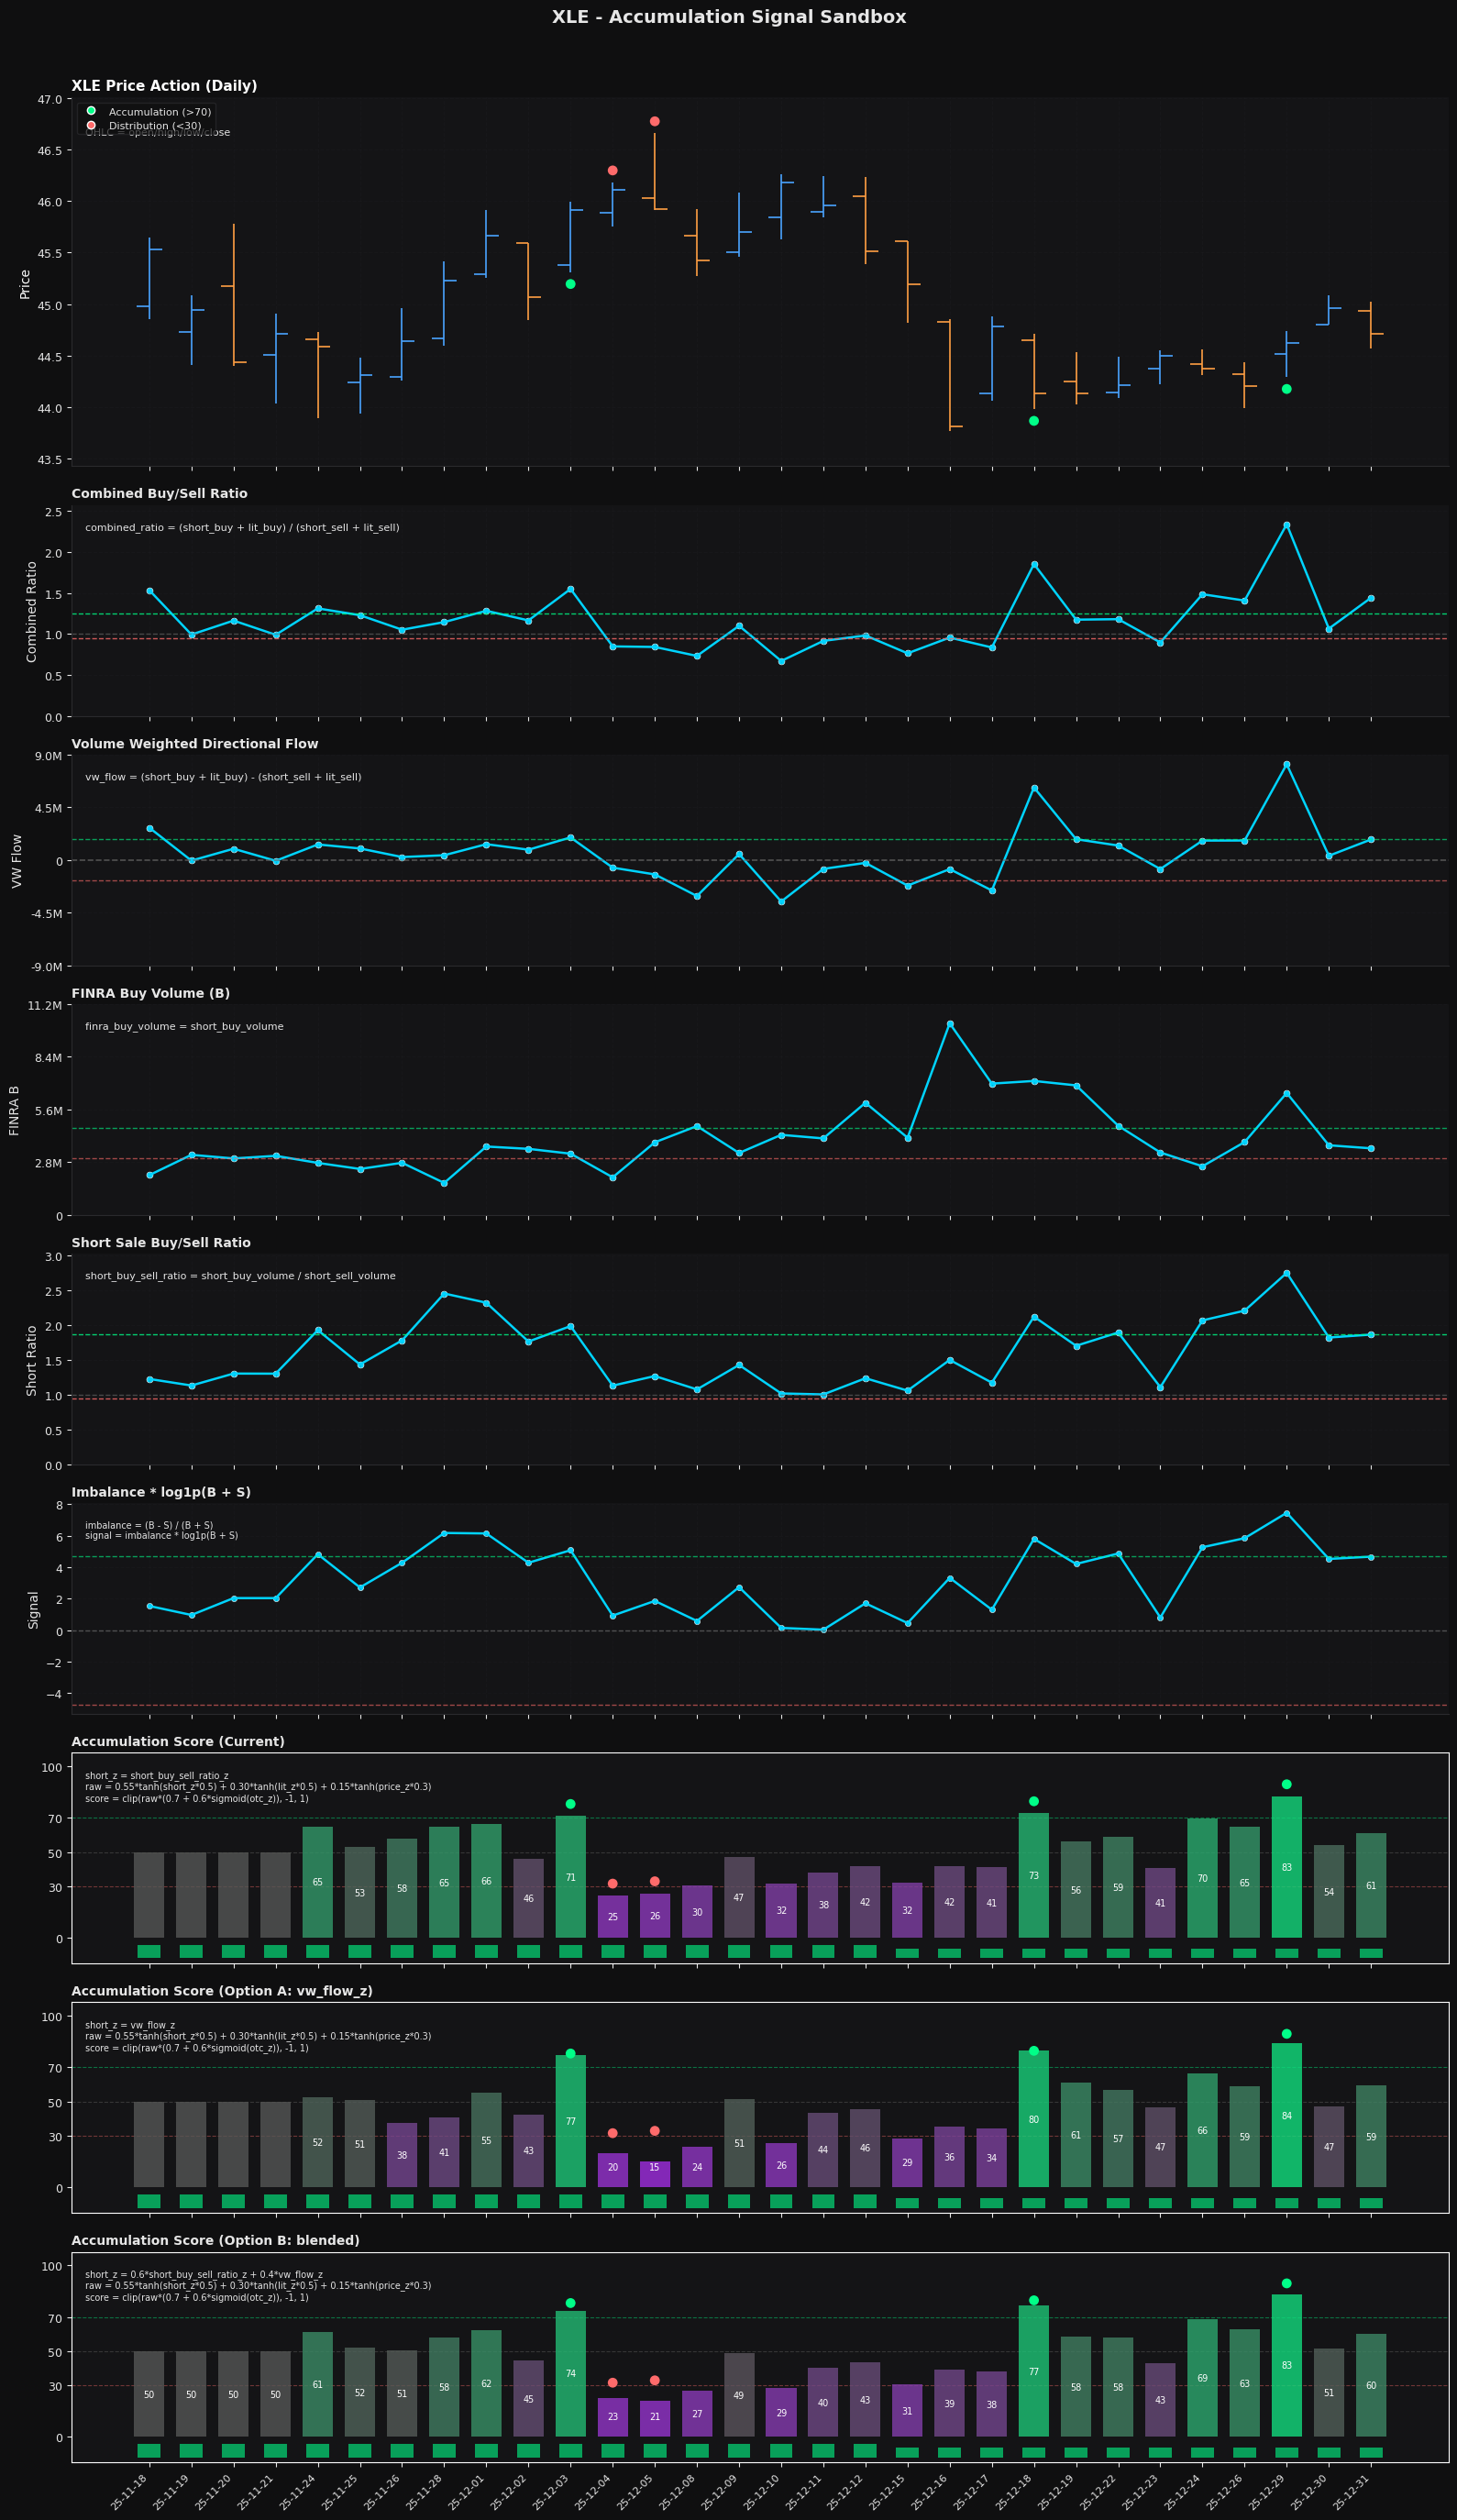

In [54]:
# Cell 4 - Main Visualization (9-Panel Chart with OHLC)
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

plt.style.use('dark_background')
fig, axes = plt.subplots(
    9,
    1,
    figsize=(16, 28),
    sharex=True,
    gridspec_kw={'height_ratios': [3.5, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]},
)
fig.patch.set_facecolor(COLORS['background'])

x = np.arange(len(df))
labels = df['date'].dt.strftime('%y-%m-%d').tolist()

# Panel 0: OHLC Price Chart
ax = axes[0]
_apply_axis_style(ax)
_plot_ohlc_bars(ax, df, x)

# Calculate y-axis range and signal marker offset
y_min = df['low'].min()
y_max = df['high'].max()
if pd.isna(y_min) or pd.isna(y_max):
    y_min = df['close'].min()
    y_max = df['close'].max()
y_span = y_max - y_min if pd.notna(y_max) and pd.notna(y_min) else 0
if not y_span or y_span <= 0:
    y_span = float(df['close'].mean() or 1.0)
offset = y_span * 0.04

# Plot signal markers on OHLC chart
_plot_ohlc_signal_markers(ax, df, df['acc_score_current'], x, offset)
ax.set_ylim(y_min - offset * 3, y_max + offset * 3)
ax.set_ylabel('Price', color=COLORS['white'], fontsize=10)
ax.set_title(f'{TICKER} Price Action (Daily)', color=COLORS['white'], fontsize=11, fontweight='bold', loc='left')
ax.text(0.01, 0.92, 'OHLC = open/high/low/close', transform=ax.transAxes, fontsize=8, color=COLORS['text'], va='top')

# Add legend for OHLC panel
legend_handles = [
    Line2D([0], [0], marker='o', color='none', markerfacecolor=COLORS['green'],
           markeredgecolor=COLORS['white'], markersize=6, label='Accumulation (>70)'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor=COLORS['red'],
           markeredgecolor=COLORS['white'], markersize=6, label='Distribution (<30)'),
]
legend = ax.legend(
    handles=legend_handles,
    loc='upper left',
    fontsize=8,
    frameon=True,
    facecolor=COLORS['background'],
    framealpha=0.7,
    edgecolor=COLORS['grid'],
)
for text in legend.get_texts():
    text.set_color(COLORS['text'])


# Panel 1: FINRA Buy Volume (B)
ax = axes[3]
_apply_axis_style(ax)
series = df['finra_buy_volume']
mask = series.notna()
ax.plot(x[mask], series[mask], color=COLORS['cyan'], linewidth=1.8)
ax.scatter(x[mask], series[mask], color=COLORS['cyan'], s=25, edgecolors=COLORS['white'], linewidths=0.4)
_set_volume_axis(ax, series)
_add_volume_thresholds(ax, series)
ax.set_ylabel('FINRA B', color=COLORS['text'])
ax.set_title('FINRA Buy Volume (B)', color=COLORS['text'], fontsize=10, fontweight='bold', loc='left')
ax.text(0.01, 0.92, 'finra_buy_volume = short_buy_volume', transform=ax.transAxes, fontsize=8, color=COLORS['text'], va='top')

# Panel 2: Combined Buy/Sell Ratio
ax = axes[1]
_apply_axis_style(ax)
series = df['combined_ratio']
mask = series.notna()
ax.plot(x[mask], series[mask], color=COLORS['cyan'], linewidth=1.8)
ax.scatter(x[mask], series[mask], color=COLORS['cyan'], s=25, edgecolors=COLORS['white'], linewidths=0.4)
short_buy_line, short_sell_line = _ratio_thresholds(series)
_set_ratio_axis(ax, series, bot=short_buy_line, sell=short_sell_line)
ax.set_ylabel('Combined Ratio', color=COLORS['text'])
ax.set_title('Combined Buy/Sell Ratio', color=COLORS['text'], fontsize=10, fontweight='bold', loc='left')
ax.text(0.01, 0.92, 'combined_ratio = (short_buy + lit_buy) / (short_sell + lit_sell)', transform=ax.transAxes, fontsize=8, color=COLORS['text'], va='top')

# Panel 3: VW Flow
ax = axes[2]
_apply_axis_style(ax)
series = df['vw_flow']
mask = series.notna()
ax.plot(x[mask], series[mask], color=COLORS['cyan'], linewidth=1.8)
ax.scatter(x[mask], series[mask], color=COLORS['cyan'], s=25, edgecolors=COLORS['white'], linewidths=0.4)
_set_flow_axis(ax, series)
_add_flow_thresholds(ax, series)
ax.set_ylabel('VW Flow', color=COLORS['text'])
ax.set_title('Volume Weighted Directional Flow', color=COLORS['text'], fontsize=10, fontweight='bold', loc='left')
ax.text(0.01, 0.92, 'vw_flow = (short_buy + lit_buy) - (short_sell + lit_sell)', transform=ax.transAxes, fontsize=8, color=COLORS['text'], va='top')

# Panel 4: Short Sale Buy/Sell Ratio
ax = axes[4]
_apply_axis_style(ax)
series = df['short_buy_sell_ratio']
mask = series.notna()
ax.plot(x[mask], series[mask], color=COLORS['cyan'], linewidth=1.8)
ax.scatter(x[mask], series[mask], color=COLORS['cyan'], s=25, edgecolors=COLORS['white'], linewidths=0.4)
short_buy_line, short_sell_line = _ratio_thresholds(series)
_set_ratio_axis(ax, series, bot=short_buy_line, sell=short_sell_line)
ax.set_ylabel('Short Ratio', color=COLORS['text'])
ax.set_title('Short Sale Buy/Sell Ratio', color=COLORS['text'], fontsize=10, fontweight='bold', loc='left')
ax.text(0.01, 0.92, 'short_buy_sell_ratio = short_buy_volume / short_sell_volume', transform=ax.transAxes, fontsize=8, color=COLORS['text'], va='top')

# Panel 5: Imbalance * log1p(B + S)
ax = axes[5]
_apply_axis_style(ax)
b = df['finra_buy_volume']
s = df['short_sell_volume']
total = b + s
imbalance = np.where(total > 0, (b - s) / total, np.nan)
signal = imbalance * np.log1p(total)
series = pd.Series(signal, index=df.index)
mask = series.notna()
ax.plot(x[mask], series[mask], color=COLORS['cyan'], linewidth=1.8)
ax.scatter(x[mask], series[mask], color=COLORS['cyan'], s=20, edgecolors=COLORS['white'], linewidths=0.4)
ax.axhline(0.0, color=COLORS['neutral'], linestyle='--', linewidth=1.0, alpha=0.7)
_add_flow_thresholds(ax, series)
ax.set_ylabel('Signal', color=COLORS['text'])
ax.set_title('Imbalance * log1p(B + S)', color=COLORS['text'], fontsize=10, fontweight='bold', loc='left')
ax.text(0.01, 0.92, 'imbalance = (B - S) / (B + S)\nsignal = imbalance * log1p(B + S)', transform=ax.transAxes, fontsize=7, color=COLORS['text'], va='top')


dot_sources = {
    'current': df['acc_score_current'],
    'option_a': df['acc_score_a'],
    'option_b': df['acc_score_b'],
}

# Panel 6: Accumulation Score (Current)
ax = axes[6]
ax.set_facecolor(COLORS['panel_bg'])
ax.tick_params(colors=COLORS['text'], labelsize=9)
_plot_score_panel(ax, x, df['acc_score_current'], df['confidence'], 'Accumulation Score (Current)', DOT_MODE, dot_sources)
ax.text(0.01, 0.92, 'short_z = short_buy_sell_ratio_z\nraw = 0.55*tanh(short_z*0.5) + 0.30*tanh(lit_z*0.5) + 0.15*tanh(price_z*0.3)\nscore = clip(raw*(0.7 + 0.6*sigmoid(otc_z)), -1, 1)', transform=ax.transAxes, fontsize=7, color=COLORS['text'], va='top')

# Panel 7: Accumulation Score (Option A: vw_flow_z)
ax = axes[7]
ax.set_facecolor(COLORS['panel_bg'])
ax.tick_params(colors=COLORS['text'], labelsize=9)
_plot_score_panel(ax, x, df['acc_score_a'], df['confidence'], 'Accumulation Score (Option A: vw_flow_z)', DOT_MODE, dot_sources)
ax.text(0.01, 0.92, 'short_z = vw_flow_z\nraw = 0.55*tanh(short_z*0.5) + 0.30*tanh(lit_z*0.5) + 0.15*tanh(price_z*0.3)\nscore = clip(raw*(0.7 + 0.6*sigmoid(otc_z)), -1, 1)', transform=ax.transAxes, fontsize=7, color=COLORS['text'], va='top')

# Panel 8: Accumulation Score (Option B: blended)
ax = axes[8]
ax.set_facecolor(COLORS['panel_bg'])
ax.tick_params(colors=COLORS['text'], labelsize=9)
_plot_score_panel(ax, x, df['acc_score_b'], df['confidence'], 'Accumulation Score (Option B: blended)', DOT_MODE, dot_sources)
ax.text(0.01, 0.92, 'short_z = 0.6*short_buy_sell_ratio_z + 0.4*vw_flow_z\nraw = 0.55*tanh(short_z*0.5) + 0.30*tanh(lit_z*0.5) + 0.15*tanh(price_z*0.3)\nscore = clip(raw*(0.7 + 0.6*sigmoid(otc_z)), -1, 1)', transform=ax.transAxes, fontsize=7, color=COLORS['text'], va='top')

axes[-1].set_xticks(x)
axes[-1].set_xticklabels(labels, rotation=45, ha='right', fontsize=8)

fig.suptitle(f'{TICKER} - Accumulation Signal Sandbox', color=COLORS['text'], fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
